In [201]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.nn import Sequential as seq
from torch.nn import Conv1d as c1d
from torch.nn import MaxPool1d as m1d
from torch.nn import Linear as l_n
from torch.nn import Dropout as drop
from torch.nn import ReLU as rel
from torch.nn.functional import nll_loss as nll_loss
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import cv2
import tabulate
from torchsummary import summary


In [2]:
class CharacterConvolutionNetwork(nn.Module):
    def __init__(self, n_classes=4, input_length=1014, input_dim=68):
        self.ker_siz=[7,7,3,3,3,3]
        super(CharacterConvolutionNetwork, self).__init__()
        self.conv1 = seq(c1d(input_dim, 256, kernel_size=self.ker_siz[0]), rel(),
                                   nn.MaxPool1d(3))
        self.conv2 = seq(c1d(256, 256, kernel_size=self.ker_siz[1], padding=0), rel(),
                                   nn.MaxPool1d(3))
        self.conv3 = seq(c1d(256, 256, kernel_size=self.ker_siz[2], padding=0), rel())
        self.conv4 = seq(c1d(256, 256, kernel_size=self.ker_siz[3], padding=0), rel())
        self.conv5 = seq(c1d(256, 256, kernel_size=self.ker_siz[4], padding=0), rel())
        self.conv6 = seq(c1d(256, 256, kernel_size=self.ker_siz[5], padding=0), rel(),
                                   nn.MaxPool1d(3))

        dimension = int((input_length - 96) / 27 * 256)
        self.fc1 = seq(l_n(dimension, 1024), drop(0.5))
        self.fc2 = seq(l_n(1024, 1024), drop(0.5))
        self.fc3 = l_n(1024, n_classes)
        mn = 0.0
        std_dev = 0.05
        self._weights(mean=mn, std=std_dev)

    def _weights(self, mean=0, std=0.05):
        for module in self.modules():
            if isinstance(module, c1d) or isinstance(module, l_n):
                module.weight.data.normal_(mean, std)

    def forward(self, inp):
        inp = inp.transpose(1, 2)
        y = self.conv1(inp)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.conv4(y)
        y = self.conv5(y)
        y = self.conv6(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y

In [4]:
characterConvolutionNetwork = CharacterConvolutionNetwork(4)
print(characterConvolutionNetwork)

CharacterConvolutionNetwork(
  (conv1): Sequential(
    (0): Conv1d(68, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8704, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=Fal

In [5]:
class Config:
    def __init__(self):
        self.train=False
        self.model_dict_path='./model_dict.pth'
        

In [6]:
data=pd.read_csv(r'./dataset/train.csv')
train_df=pd.DataFrame(data,columns=["class","title","desc"])
print(train_df)

        class                                              title  \
0           3  Wall St. Bears Claw Back Into the Black (Reuters)   
1           3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2           3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3           3  Iraq Halts Oil Exports from Main Southern Pipe...   
4           3  Oil prices soar to all-time record, posing new...   
...       ...                                                ...   
119995      1  Pakistan's Musharraf Says Won't Quit as Army C...   
119996      2                  Renteria signing a top-shelf deal   
119997      2                    Saban not going to Dolphins yet   
119998      2                                  Today's NFL games   
119999      2                       Nets get Carter from Raptors   

                                                     desc  
0       Reuters - Short-sellers, Wall Street's dwindli...  
1       Reuters - Private investment firm Carlyle Grou...  
2  

In [56]:
data=pd.read_csv(r'./dataset/test.csv')
test_df=pd.DataFrame(data,columns=["class","title","desc"])
print(test_df)

      class                                              title  \
0         3                  Fears for T N pension after talks   
1         4  The Race is On: Second Private Team Sets Launc...   
2         4      Ky. Company Wins Grant to Study Peptides (AP)   
3         4      Prediction Unit Helps Forecast Wildfires (AP)   
4         4        Calif. Aims to Limit Farm-Related Smog (AP)   
...     ...                                                ...   
7595      1                                   Around the world   
7596      2                        Void is filled with Clement   
7597      2                             Martinez leaves bitter   
7598      3  5 of arthritis patients in Singapore take Bext...   
7599      3                             EBay gets into rentals   

                                                   desc  
0     Unions representing workers at Turner   Newall...  
1     SPACE.com - TORONTO, Canada -- A second\team o...  
2     AP - A company founded by a

In [8]:
class TextDataset(Dataset):
    def __init__(self,df, max_length=1014):
#         self.data_path = data_path
        strr="""abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"""
        self.vocabulary = list(strr)

        self.identity_mat = np.identity(len(self.vocabulary))
        texts, labels = [], []
        
        self.labels = [int(i)-1 for i in df['class'].values]
        self.num_classes = len(set(self.labels))
        self.length = len(self.labels)
        self.texts = df['desc'].values
        self.max_length = max_length


    def __getitem__(self, index):
        raw_text = self.texts[index]
        isi_text = self.texts[index]
        vocabb= self.vocabulary
        data = np.array([self.identity_mat[self.vocabulary.index(i)] for i in list(raw_text) if i in vocabb], dtype=np.float32)

        if len(data) == 0:
            data = np.zeros((self.max_length, len(self.vocabulary)), dtype=np.float32)
        
        
        elif self.max_length > len(data) > 0 :
            data = np.concatenate((data, np.zeros((-(len(data) - self.max_length), len(self.vocabulary)), dtype=np.float32)))
        
        elif  self.max_length < len(data):
            data = data[:self.max_length]
        
        label = self.labels[index]
        
        return data, label

    def __len__(self):
        return self.length
        

In [9]:
trainset=TextDataset(train_df)

In [10]:
train_siz=int(0.9*120000)
valid_siz=120000-train_siz

trainset,valset=torch.utils.data.random_split(trainset, [train_siz,valid_siz])

In [11]:
trainloader = DataLoader(trainset, batch_size=128, num_workers=2, drop_last=True, shuffle=True)

In [12]:
optimizer = optim.SGD(characterConvolutionNetwork.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [13]:
cnf=Config()

In [14]:
epochs=8

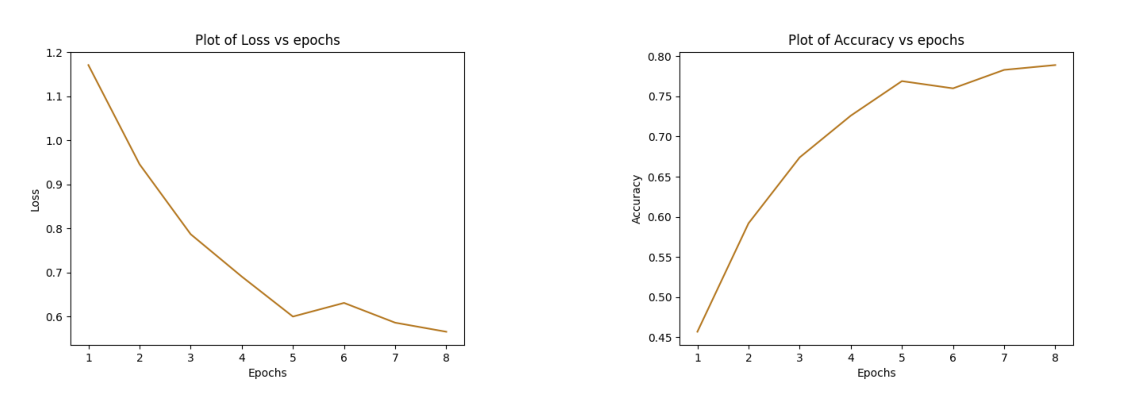

In [15]:
if cnf.train:
    for i in range(epochs):
        running_loss=0
        for j,data in enumerate(trainloader,0):
            x,y=data
    #         print(x,y)
            x=Variable(x)
            y=Variable(y)
            optimizer.zero_grad()
            out=characterConvolutionNetwork(x)
            loss=nll_loss(out,y)
            loss.backward()
            optimizer.step()
            if j%100==0:
                print(loss.data)
else:
    plt1=cv2.imread('./plot1.png')
    plt2=cv2.imread('./plot2.png')

    fig=plt.figure(figsize=(20,12))
    r=1
    c=2
    fig.add_subplot(r,c,1)
    plt.imshow(plt1,cmap='gray')
    plt.axis('off')

    fig.add_subplot(r,c,2)
    plt.imshow(plt2,cmap='gray')
    plt.axis('off')

In [16]:
if cnf.train:
    torch.save(characterConvolutionNetwork.state_dict(), cnf.model_dict_path)
    

In [57]:
model = CharacterConvolutionNetwork(4)
model.load_state_dict(torch.load('./model_dict.pth'))
model.eval()

CharacterConvolutionNetwork(
  (conv1): Sequential(
    (0): Conv1d(68, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8704, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=Fal

In [58]:
testset=TextDataset(test_df)

In [59]:
testloader = DataLoader(testset,batch_size=128, num_workers=2, drop_last=True, shuffle=True)
# print(next(iter(testloader)))
pr=[]
ac=[]

In [60]:
cnt=0
match=0
for j,data in enumerate(testloader,0):
        
        m1=0
        x,y=data
        x=Variable(x)
        y=Variable(y)
        out=model(torch.reshape(x,(128,1014,68)))
        lab=[]
        for i in out:
            mx=-1e9
            midx=0
            for x in range(4):
                if i[x]>mx:
                    mx=i[x]
                    midx=x
            lab.append(midx)
        for i in range(128):
            if y[i]==lab[i]:
                match+=1
            pr.append(lab[i])
            ac.append(y[i])
print("accuracy",str(match*100/len(testset)),"%%")
        

accuracy 74.94736842105263 %%


In [74]:
print(match)

68149


In [114]:
def sm(pred,test,i,case):
    cnt=0
    for x in range(len(pred)):
        if case=='tp':
            if pred[x]==i and test[x]==i:
                cnt+=1
        elif case=='tn':
            if pred[x]!=i and test[x]!=i:
                cnt+=1
        elif case=='fp':
            if pred[x]!=i and test[x]==i:
                cnt+=1
        elif case=='fn':
            if pred[x]==i and test[x]!=i:
                cnt+=1
    return cnt       
        

In [115]:
def findMet(pred,test,nclass):
    tp=[0 for i in range(nclass)]
    tn=[0 for i in range(nclass)]
    fp=[0 for i in range(nclass)]
    fn=[0 for i in range(nclass)]
    for i in range(nclass):
        tp[i]=sm(pred,test,i,'tp')
        tn[i]=sm(pred,test,i,'tn')
        fp[i]=sm(pred,test,i,'fp')
        fn[i]=sm(pred,test,i,'fn')
    return tp,tn,fp,fn
    

In [116]:
tp,tn,fp,fn=findMet(pred=ac,test=pr,nclass=4)
acc=sum(tp)+sum(tn)
print(sum(tp))
acc/=(sum(tp)+sum(tn)+sum(fp)+sum(fn))
print(acc)

5696
0.8771186440677966


In [216]:
ac_sc=accuracy_score(ac,pr)
pr_sc=precision_score(ac,pr,average=None).tolist()
rc_sc=recall_score(ac,pr,average=None).tolist()
f1_sc=f1_score(ac,pr,average=None).tolist()
print("accuracy",100*ac_sc,"%")

accuracy 75.42372881355932 %


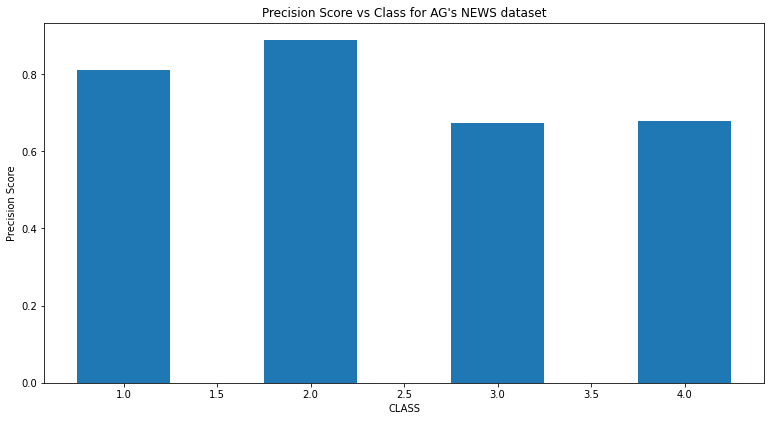

In [210]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
classes=[i for i in range(1,5)]
ax.bar(classes,pr_sc,width=0.5)
plt.xlabel('CLASS')
plt.ylabel('Precision Score')
plt.title('Precision Score vs Class for AG\'s NEWS dataset')
plt.show()

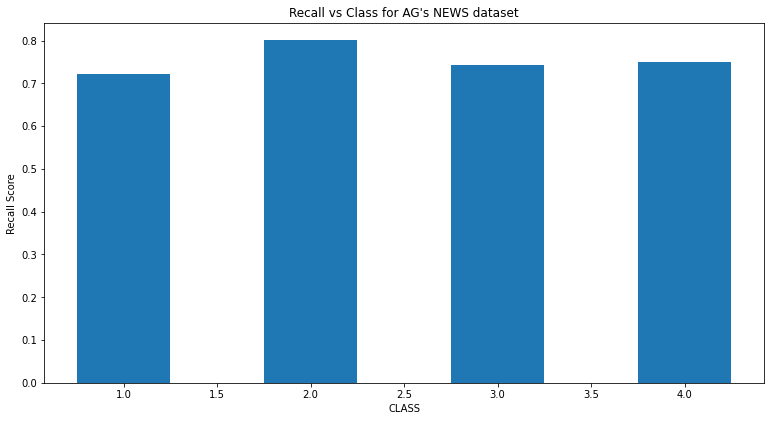

In [211]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
classes=[i for i in range(1,5)]
ax.bar(classes,rc_sc,width=0.5)
plt.xlabel('CLASS')
plt.ylabel('Recall Score')
plt.title('Recall vs Class for AG\'s NEWS dataset')
plt.show()

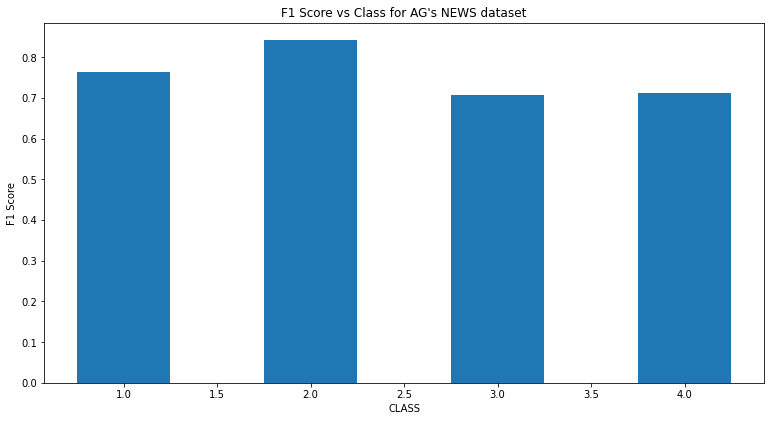

In [212]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
classes=[i for i in range(1,5)]
ax.bar(classes,f1_sc,width=0.5)
plt.xlabel('CLASS')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Class for AG\'s NEWS dataset')
plt.show()

In [213]:

pr_sc.insert(0,'Precision')
rc_sc.insert(0,'Recall')
f1_sc.insert(0,'F1_score')
# print(x)
heading=['Type','Class 1','Class 2','Class 3','Class 4']
table=[heading,pr_sc,rc_sc,f1_sc]
# print(table)
print(tabulate.tabulate(table,headers='firstrow'))

Type         Class 1    Class 2    Class 3    Class 4
---------  ---------  ---------  ---------  ---------
Precision   0.810827   0.888694   0.674049   0.678486
Recall      0.722694   0.801373   0.742312   0.750397
F1_score    0.764228   0.842778   0.706535   0.712632


In [28]:
data=pd.read_csv(r'./dbpedia/train.csv')
train_df=pd.DataFrame(data,columns=["class","title","desc"])
print(train_df)

        class                              title  \
0           1                   E. D. Abbott Ltd   
1           1                     Schwan-Stabilo   
2           1                         Q-workshop   
3           1  Marvell Software Solutions Israel   
4           1        Bergan Mercy Medical Center   
...       ...                                ...   
559995     14                   Barking in Essex   
559996     14                   Science & Spirit   
559997     14             The Blithedale Romance   
559998     14                Razadarit Ayedawbon   
559999     14           The Vinyl Cafe Notebooks   

                                                     desc  
0        Abbott of Farnham E D Abbott Limited was a Br...  
1        Schwan-STABILO is a German maker of pens for ...  
2        Q-workshop is a Polish company located in Poz...  
3        Marvell Software Solutions Israel known as RA...  
4        Bergan Mercy Medical Center is a hospital loc...  
...            

In [61]:
data=pd.read_csv(r'./dbpedia/test.csv')
test_df1=pd.DataFrame(data,columns=["class","title","desc"])
print(test_df1)

       class                     title  \
0          1                     TY KU   
1          1     Odd Lot Entertainment   
2          1                    Henkel   
3          1                GOAT Store   
4          1  RagWing Aircraft Designs   
...      ...                       ...   
69995     14            Energy Victory   
69996     14                 Bestiario   
69997     14         Wuthering Heights   
69998     14             L'Indépendant   
69999     14      The Prophecy (novel)   

                                                    desc  
0       TY KU /taɪkuː/ is an American alcoholic bever...  
1       OddLot Entertainment founded in 2001 by longt...  
2       Henkel AG & Company KGaA operates worldwide w...  
3       The GOAT Store (Games Of All Type Store) LLC ...  
4       RagWing Aircraft Designs (also called the Rag...  
...                                                  ...  
69995   Energy Victory: Winning the War on Terror by ...  
69996   Bestiario is a 

In [62]:
testset=TextDataset(test_df1)
model1 = CharacterConvolutionNetwork(14)
model1.load_state_dict(torch.load('./dbpedia_model_dict.pth'))
model1.eval()

CharacterConvolutionNetwork(
  (conv1): Sequential(
    (0): Conv1d(68, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (conv6): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8704, out_features=1024, bias=True)
    (1): Dropout(p=0.5, inplace=Fal

In [63]:
testloader = DataLoader(testset,batch_size=128, num_workers=2, drop_last=True, shuffle=True)
pr1=[]
ac1=[]

In [64]:
cnt=0
match=0
for j,data in enumerate(testloader,0):
#         print(j)
        m1=0
        x,y=data
        x=Variable(x)
        y=Variable(y)
        out=model1(torch.reshape(x,(128,1014,68)))
        lab=[]
        for i in out:
            mx=-1e9
            midx=0
            for x in range(14):
                if i[x]>mx:
                    mx=i[x]
                    midx=x
            lab.append(midx)
        for i in range(128):
            if y[i]==lab[i]:
                match+=1
            pr1.append(lab[i])
            ac1.append(y[i])
print("accuracy",str(match*100/len(testset)),"%%")
        

accuracy 97.35571428571428 %%


In [112]:
tp,tn,fp,fn=findMet(pred=ac1,test=pr1,nclass=14)
acc=sum(tp)+sum(tn)
acc/=(sum(tp)+sum(tn)+sum(fp)+sum(fn))
print(acc)

0.9964453329408687


In [191]:
ac_sc=accuracy_score(ac1,pr1).tolist()
pr_sc=precision_score(ac1,pr1,average=None).tolist()
rc_sc=recall_score(ac1,pr1,average=None).tolist()
f1_sc=f1_score(ac1,pr1,average=None).tolist()


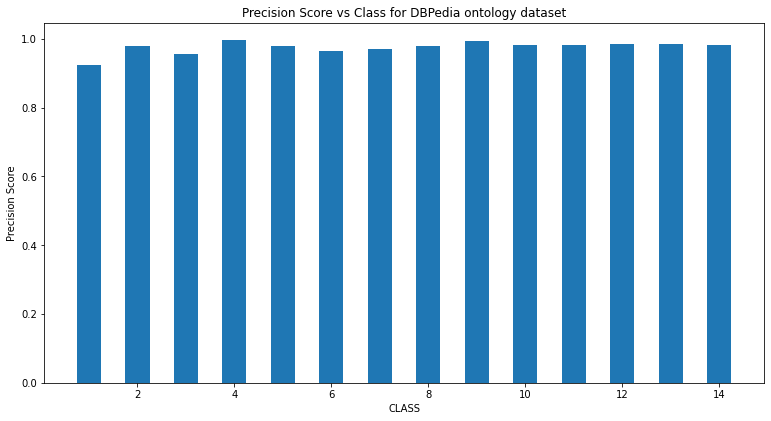

In [192]:

fig=plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
classes=[i for i in range(1,15)]
ax.bar(classes,pr_sc,width=0.5)
plt.xlabel('CLASS')
plt.ylabel('Precision Score')
plt.title('Precision Score vs Class for DBPedia ontology dataset')
plt.show()

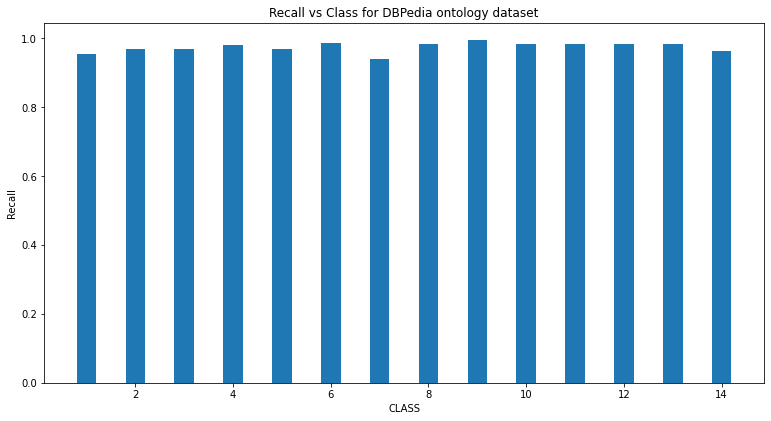

In [193]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
classes=[i for i in range(1,15)]
ax.bar(classes,rc_sc,width=0.4)
plt.xlabel('CLASS')
plt.ylabel('Recall')
plt.title('Recall vs Class for DBPedia ontology dataset')
plt.show()

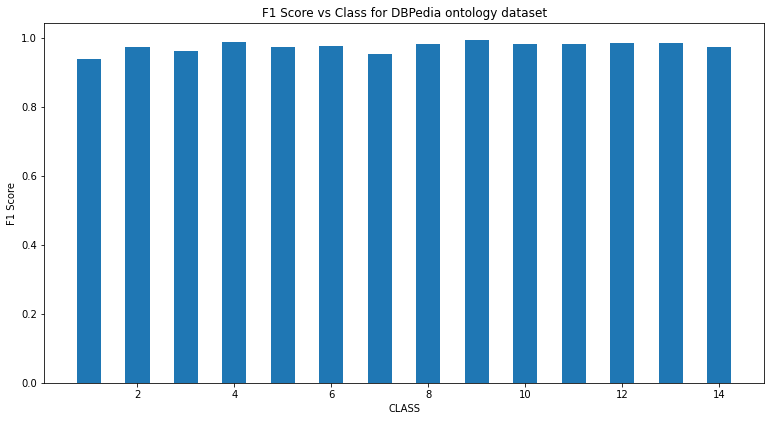

In [194]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
classes=[i for i in range(1,15)]
ax.bar(classes,f1_sc,width=0.5)
plt.xlabel('CLASS')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Class for DBPedia ontology dataset')
plt.show()

In [217]:
ac_sc=accuracy_score(ac1,pr1).tolist()
pr_sc=precision_score(ac1,pr1,average=None).tolist()
rc_sc=recall_score(ac1,pr1,average=None).tolist()
f1_sc=f1_score(ac1,pr1,average=None).tolist()
print("accuracy",100*ac_sc,"%")
pr_sc.insert(0,'Precision')
rc_sc.insert(0,'Recall')
f1_sc.insert(0,'F1_score')
# print(x)
heading=['Type']
for i in range(1,15):
    heading.append('Class'+str(i))
table=[heading,pr_sc,rc_sc,f1_sc]
t1=[]
for i in range(15):
    temp=[]
    for j in range(4):
        temp.append(table[j][i])
    t1.append(temp)
        
# print(t1)
print(tabulate.tabulate(t1,headers='firstrow'))

accuracy 97.51173305860806 %
Type       Precision    Recall    F1_score
-------  -----------  --------  ----------
Class1      0.922482  0.955929    0.938908
Class2      0.979555  0.969157    0.974328
Class3      0.95495   0.968149    0.961504
Class4      0.996745  0.982161    0.989399
Class5      0.978353  0.969138    0.973724
Class6      0.965639  0.985769    0.9756
Class7      0.969841  0.939752    0.954559
Class8      0.978118  0.984976    0.981535
Class9      0.99281   0.995394    0.994101
Class10     0.98259   0.983771    0.98318
Class11     0.982393  0.983574    0.982983
Class12     0.983984  0.984773    0.984378
Class13     0.983593  0.984776    0.984184
Class14     0.983262  0.964364    0.973721
